# SMI Model
#### This model is built based on random forest algorithm

In [1]:
from osgeo import gdal, gdal_array
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib
import matplotlib.cm as colormap
import matplotlib.pyplot as pyplot
gdal.UseExceptions()
gdal.AllRegister()

# Create the model

In [2]:
#read dataset for creating model
stacked_training = gdal.Open('training_data/stacked_indicies_kampar.tif', gdal.GA_ReadOnly)
smi_training = gdal.Open('training_data/smi_training_1.tif', gdal.GA_ReadOnly)

In [3]:
#convert dataset to array then create features and labels for training purposes
stacked_zeros = np.zeros((stacked_training.RasterYSize, stacked_training.RasterXSize, stacked_training.RasterCount),
                            gdal_array.GDALTypeCodeToNumericTypeCode(stacked_training.GetRasterBand(1).DataType))
for a in range(stacked_zeros.shape[2]):
    stacked_zeros[:, :, a] = stacked_training.GetRasterBand(a + 1).ReadAsArray()
smi_model_building = smi_training.GetRasterBand(1).ReadAsArray().astype(np.float32)
smi_masked_training = np.ma.masked_where(smi_model_building == 0, smi_model_building)
x = stacked_zeros[smi_model_building > 0, :] #feature
y = smi_model_building[smi_model_building > 0] #label
print('X shape {x} and Y shape {y}'.format(x = x.shape, y = y.shape))

X shape (176810, 15) and Y shape (176810,)


In [4]:
#split dataset to training and test data by 75% and 25%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)
print('Training features shape :', x_train.shape)
print('Training labels shape :', y_train.shape)
print('Testing features shape', x_test.shape)
print('Testing labels shape:', y_test.shape)

Training features shape : (132607, 15)
Training labels shape : (132607,)
Testing features shape (44203, 15)
Testing labels shape: (44203,)


In [5]:
#train our model by using training data and predict it
rf_reg = RandomForestRegressor(bootstrap= True, n_estimators = 200, max_depth = None, 
                              max_features = 'auto', min_samples_leaf = 1, min_samples_split = 2, random_state = 42)
rf_reg.fit(x_train, y_train)
print('Model trained ...')

Model trained ...


In [6]:
#calculate statistics of model result
train_prediction = rf_reg.predict(x_test)
err = abs(train_prediction - y_test)
print('MAE:', round(np.mean(err), 2), 'degrees.')
mape = 100 * (err / y_test)
acc = 100 - np.mean(mape)
print('Accuracy', round(acc, 2), '%.')
rsq = r2_score(y_test, train_prediction)
print('Our R Squared score is {r}'.format(r = rsq))

MAE: 0.08 degrees.
Accuracy 83.36 %.
Our R Squared score is 0.5526341224757939


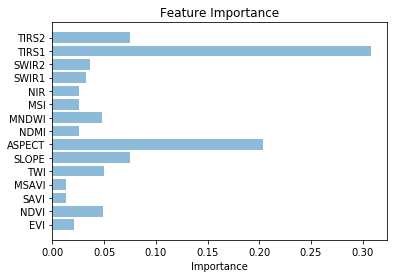

In [7]:
# feature importance
features_raster = ["EVI", "NDVI", "SAVI", "MSAVI", "TWI", "SLOPE", "ASPECT", 
                    "NDMI", "MNDWI", "MSI", "NIR", "SWIR1", "SWIR2", "TIRS1", "TIRS2"]
imp = rf_reg.feature_importances_
ftr = np.arange(len(features_raster))
pyplot.barh(ftr, imp, align="center", alpha=0.5)
pyplot.yticks(ftr, features_raster)
pyplot.xlabel('Importance')
pyplot.title('Feature Importance')
pyplot.savefig('results/feature_importance_kampar.png', dpi = 192)
pyplot.show()

In [8]:
def save_raster(out_name, ras_shape_1, ras_shape_0, ras, ras_geo_transform, ras_projection):
    driver = gdal.GetDriverByName("GTiff")
    src = driver.Create(out_name, ras_shape_1, ras_shape_0, 1, gdal.GDT_Float32)
    band = src.GetRasterBand(1)
    band.WriteArray(ras)
    band.SetNoDataValue(0)
    src.SetGeoTransform(ras_geo_transform)
    src.SetProjection(ras_projection)
    del band
    del src
    success = print('result saved')
    return success

# Model verification

In [9]:
#read dataset for model verification
stacked_verification = gdal.Open('verification_data/scenario_2/stacked_indicies_kampar_verification_30jan18.tif', gdal.GA_ReadOnly)
smi_verification = gdal.Open('verification_data/scenario_2/smi_kampar_verification_26ags18.tif', gdal.GA_ReadOnly)

In [10]:
#convert dataset to array then create features and labels for verification
verification_zeros = np.zeros((stacked_verification.RasterYSize, stacked_verification.RasterXSize, stacked_verification.RasterCount),
                            gdal_array.GDALTypeCodeToNumericTypeCode(stacked_verification.GetRasterBand(1).DataType))
for a in range(verification_zeros.shape[2]):
    verification_zeros[:, :, a] = stacked_verification.GetRasterBand(a + 1).ReadAsArray()
smi = smi_verification.GetRasterBand(1).ReadAsArray().astype(np.float32)
smi_masked_verification = np.ma.masked_where(smi == 0, smi)
x_verification = verification_zeros[smi > 0, :] #feature
y_verification = smi[smi > 0] #label
print('X shape {x} and Y shape {y}'.format(x = x_verification.shape, y = y_verification.shape))

X shape (167771, 15) and Y shape (167771,)


In [11]:
#split dataset to training and test data by 75% and 25%
x_train_verification, x_test_verification, y_train_verification, y_test_verification = train_test_split(x_verification, y_verification, test_size = 0.25, random_state = 42)
print('Training features shape :', x_train_verification.shape)
print('Training labels shape :', y_train_verification.shape)
print('Testing features shape', x_test_verification.shape)
print('Testing labels shape:', y_test_verification.shape)

Training features shape : (125828, 15)
Training labels shape : (125828,)
Testing features shape (41943, 15)
Testing labels shape: (41943,)


In [12]:
#reshape training area
new_verification_shape = (verification_zeros.shape[0] * verification_zeros.shape[1], verification_zeros.shape[2])
training_area_image = verification_zeros[:, :, :15].reshape(new_verification_shape)
print('Reshaped study area image from {o} to {n}'.format(o = verification_zeros.shape, n = training_area_image.shape))
#predict training area
training_area_prediction = rf_reg.predict(training_area_image)
#masking the result
training_area_result = training_area_prediction.reshape(verification_zeros[:, :, 0].shape)
masked_training_area_result = np.ma.masked_where(training_area_result == 0, training_area_result)

Reshaped study area image from (296, 570, 15) to (168720, 15)


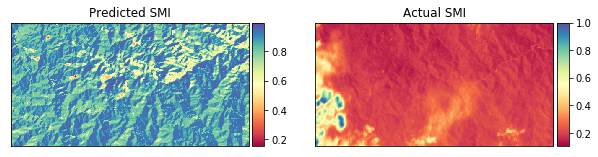

In [17]:
#display verification result
fig, (ax1, ax2) = pyplot.subplots(1,2, figsize = (10,3))
ax1.set_facecolor('#ffffff')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
img_smi_verification = ax1.imshow(training_area_result, cmap = colormap.get_cmap('Spectral'))
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_smi_verification, cax = cax1)
ax1.set_title('Predicted SMI')

ax2.set_facecolor('#ffffff')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
img_smi_training_actual = ax2.imshow(smi_masked_verification, cmap = colormap.get_cmap('Spectral'))
ax2.set_title('Actual SMI')
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_smi_training_actual, cax = cax2)
pyplot.savefig('results/verification_result_image.png', dpi = 192)
pyplot.show()

In [14]:
#calculate mean absolute errors
training_area_statistics = rf_reg.predict(x_test_verification)
err_verification = abs(training_area_statistics - y_test_verification)
print('MAE:', round(np.mean(err_verification), 2), 'degrees.')
#calculate accuracy
mape_verification = 100 * (err_verification / y_test_verification)
acc_verification = 100 - np.mean(mape_verification)
print('Accuracy', round(acc_verification, 2), '%.')
#calculate R-squared
rsq_verification = r2_score(y_test_verification, training_area_statistics)
print('Our R Squared score for verification is {r}'.format(r = rsq_verification))

MAE: 0.62 degrees.
Accuracy -200.93 %.
Our R Squared score for verification is -37.659672954577424


In [24]:
#save the verification result to raster (.tiff)
ras_geo_transform = smi_verification.GetGeoTransform()
ras_projection = smi_verification.GetProjection()
namefile = 'results/smi_verification_result.tif'
ras_shape_1 = masked_training_area_result.shape[1]
ras_shape_0 = masked_training_area_result.shape[0]
ras = masked_training_area_result

save_raster(namefile, ras_shape_1, ras_shape_0, ras, ras_geo_transform, ras_projection)

result saved


# Model testing against study area

In [15]:
#read study area raster dataset
stacked_testing = gdal.Open('test_data/scenario_2/stacked_indicies_kampar_testing_30jan18.tif', gdal.GA_ReadOnly) #dir can be changed
smi_testing = gdal.Open('test_data/scenario_2/smi_kampar_testing_26ags18.tif', gdal.GA_ReadOnly) #dir can be changed

In [18]:
#convert dataset to array
testing_zeros = np.zeros((stacked_testing.RasterYSize, stacked_testing.RasterXSize, stacked_testing.RasterCount),
                                gdal_array.GDALTypeCodeToNumericTypeCode(stacked_testing.GetRasterBand(1).DataType))
for b in range(testing_zeros.shape[2]):
    testing_zeros[:, :, b] = stacked_testing.GetRasterBand(b + 1).ReadAsArray()
smi_study_area = smi_testing.GetRasterBand(1).ReadAsArray().astype(np.float32)
smi_study_area_masked = np.ma.masked_where(smi_study_area == 0, smi_study_area)

#create features and labels for testing purposes
x_study = testing_zeros[smi_study_area > 0, :] #feature
y_study = smi_study_area[smi_study_area > 0] #label
print('X shape {x} and Y shape {y}'.format(x = x_study.shape, y = y_study.shape))

X shape (11095048, 15) and Y shape (11095048,)


In [19]:
#split our data to train and test data by 75% and 25%
x_train_study, x_test_study, y_train_study, y_test_study = train_test_split(x_study, y_study, test_size = 0.25, random_state = 42)
print('Training features shape :', x_train_study.shape)
print('Training labels shape :', y_train_study.shape)
print('Testing features shape', x_test_study.shape)
print('Testing labels shape:', y_test_study.shape)

Training features shape : (8321286, 15)
Training labels shape : (8321286,)
Testing features shape (2773762, 15)
Testing labels shape: (2773762,)


In [22]:
#reshape study area
new_test_shape = (testing_zeros.shape[0] * testing_zeros.shape[1], testing_zeros.shape[2])
study_area_image = testing_zeros[:, :, :15].reshape(new_test_shape)
print('Reshaped study area image from {o} to {n}'.format(o = testing_zeros.shape, n = study_area_image.shape))
#predict study area
study_area_prediction = rf_reg.predict(study_area_image)
#masking the result
final_study_area_prediction = study_area_prediction.reshape(testing_zeros[:, :, 0].shape)
masked_study_area_prediction = np.ma.masked_where(final_study_area_prediction == 0, final_study_area_prediction)

Reshaped study area image from (5094, 4479, 15) to (22816026, 15)


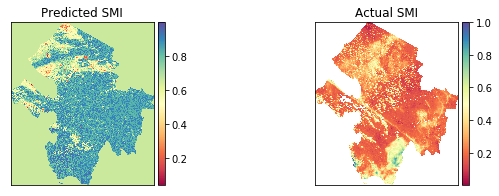

Success predict our study area


In [23]:
#display testing result
fig, (ax1, ax2) = pyplot.subplots(1,2, figsize = (10,3))
ax1.set_facecolor('#ffffff')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
img_smi_prediction = ax1.imshow(masked_study_area_prediction, cmap = colormap.get_cmap('Spectral'))
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_smi_prediction, cax = cax1)
ax1.set_title('Predicted SMI')

ax2.set_facecolor('#ffffff')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
img_smi_actual = ax2.imshow(smi_study_area_masked, cmap = colormap.get_cmap('Spectral'))
ax2.set_title('Actual SMI')
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_smi_actual, cax = cax2)
pyplot.savefig('results/testing_result_image.png', dpi = 192)
pyplot.show()

print('Success predict our study area')

In [24]:
#calculate mean absolute errors
test_prediction = rf_reg.predict(x_test_study)
err_test = abs(test_prediction - y_test_study)
print('MAE:', round(np.mean(err_test), 2), 'degrees.')
#calculate accuracy
mape_test = 100 * (err_test / y_test_study)
acc_test = 100 - np.mean(mape_test)
print('Accuracy', round(acc_test, 2), '%.')
#calculate R-squared
rsq_test = r2_score(y_test_study, test_prediction)
print('Our R Squared score for study area is {r}'.format(r = rsq_test))

MAE: 0.53 degrees.
Accuracy -168.85 %.
Our R Squared score for study area is -18.265566919191365


In [ ]:
#save the testing result to raster (.tiff)

ras_geo_transform_testing = ts_smi.GetGeoTransform()
ras_projection_testing = ts_smi.GetProjection()
namefile_testing = 'results/predicted_smi_testing.tif'
ras_shape_1_testing = masked_study_area_prediction.shape[1]
ras_shape_0_testing = masked_study_area_prediction.shape[0]
ras_testing = final_study_area_prediction

save_raster(namefile_testing, ras_shape_1_testing, ras_shape_0_testing, ras_testing, ras_geo_transform_testing, ras_projection_testing)